# Libraries

In [ ]:
import numpy as np
import pandas as pd
import os
import cv2
import random
import glob
import math
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from prettytable import PrettyTable
import random
from PIL import Image
from sklearn.model_selection import train_test_split

In [ ]:
%pip install -q --upgrade --no-cache-dir gdown
!gdown 1x0FwuF_3fbtoatMJOQBgzgebkjONx9_I

Downloading...
From (original): https://drive.google.com/uc?id=1x0FwuF_3fbtoatMJOQBgzgebkjONx9_I
From (redirected): https://drive.google.com/uc?id=1x0FwuF_3fbtoatMJOQBgzgebkjONx9_I&confirm=t&uuid=de498cf9-7e94-4de7-96d6-d21bc7967449
To: /content/products.zip
100% 249M/249M [00:02<00:00, 85.6MB/s]


In [ ]:
!unzip -q "/content/products.zip"

cp: cannot stat '/content/products': No such file or directory


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Create Dataframes

In [ ]:
def create_dataframes(folder_path):
  subfolder_paths_list = []
  train_images = []
  train_lables = []
  test_lables=[]
  test_images = []
  val_lables=[]
  val_images = []
  image_ids_list = []
  labels_list = []

  subfolder_paths_list = glob.glob(f'{folder_path}*', recursive = True)
  # classes_list = [subfolder_path.split(f"{folder_path}")[-1] for subfolder_path in subfolder_paths_list]
  num_classes = len(subfolder_paths_list)

  for subfolder_path in subfolder_paths_list:
      subfolder_name = subfolder_path.split(f"{folder_path}")[-1]
      subfolder_image_names_list = os.listdir(subfolder_path)
      random.shuffle(subfolder_image_names_list)
      # Calculate the number of images for the validation set (20% of total)
      test_count = int(0.2 * len(subfolder_image_names_list))

      # Split the list into training and validation sets
      train_image_names = subfolder_image_names_list[test_count:]
      test_image_names = subfolder_image_names_list[:test_count]

      val_count = int(0.1 * len(train_image_names))
      val_image_names = train_image_names[:val_count]
      train_image_names = train_image_names[val_count:]

      train_images.extend(train_image_names)
      train_lables.extend(list(np.repeat(subfolder_name,len(train_image_names))))
      val_images.extend(val_image_names)
      val_lables.extend(list(np.repeat(subfolder_name,len(val_image_names))))
      test_images.extend(test_image_names)
      test_lables.extend(list(np.repeat(subfolder_name,len(test_image_names))))

      image_ids_list.extend(subfolder_image_names_list)
      subfolder_images_label_list = [subfolder_name for _ in range(len(subfolder_image_names_list))]
      labels_list.extend(subfolder_images_label_list)

  indices = list(range(len(test_images)))
  random.shuffle(indices)
  # Apply the shuffled indices to both lists
  shuffled_test_images = [test_images[i] for i in indices]
  shuffled_test_lables = [test_lables[i] for i in indices]

  indices = list(range(len(val_images)))
  random.shuffle(indices)
  # Apply the shuffled indices to both lists
  shuffled_val_images = [val_images[i] for i in indices]
  shuffled_val_lables = [val_lables[i] for i in indices]

  indices = list(range(len(train_images)))
  random.shuffle(indices)
  # Apply the shuffled indices to both lists
  shuffled_train_images = [train_images[i] for i in indices]
  shuffled_train_lables = [train_lables[i] for i in indices]


  Keys = list(np.unique(np.array(labels_list), return_counts = True)[0])
  Values = list(np.unique(np.array(labels_list), return_counts = True)[1])
  S = pd.Series({Keys[i]: Values[i] for i in range(len(Keys))},
                name='article_id')
  S = S.sort_values(ascending=False)
  Cs = np.array([i for i in range(1,53)])
  Colors = cm.tab20b(Cs/float(max(Cs)))
  S.plot(kind="bar", figsize=(10,5),color=Colors)


  train_df = pd.DataFrame({
      'image_id': shuffled_train_images,
      'label': shuffled_train_lables
  })

  val_df = pd.DataFrame({
      'image_id': shuffled_val_images,
      'label': shuffled_val_lables
  })

  test_df = pd.DataFrame({
      'image_id': shuffled_test_images,
      'label': shuffled_test_lables
  })

  cls_list = list(np.unique(np.array(labels_list), return_counts = True)[0])

  return train_df, val_df, test_df, cls_list


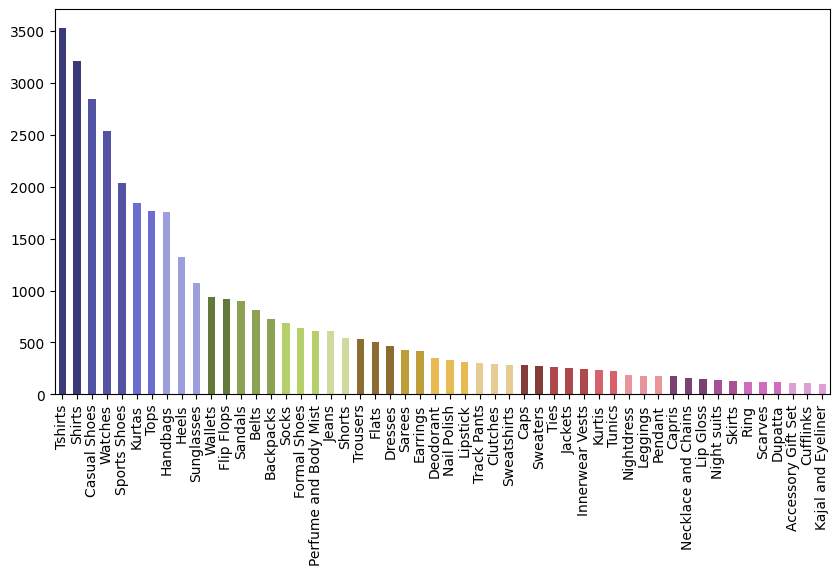

In [ ]:
train_df, valid_df, test_df, classes_list = create_dataframes('/content/categorized_products/')
num_classes = len(classes_list)

In [ ]:
img = read_image('/content/categorized_products/Accessory Gift Set/17359.jpg')
img.dtype
transform(img)        # pic should be PIL Image or ndarray
# ------------------------------------------------------------------------------
import cv2
img = cv2.imread('/content/categorized_products/Accessory Gift Set/17359.jpg')
img = Image.fromarray(img)
type(img)
# np.array(img).dtype
#-------------------------------------------------------------------------------

img = Image.open('/content/categorized_products/Wallets/37989.jpg')
type(img)
rgb_img=img.convert('RGB')
np.array(rgb_img).shape
# transform(img).dtype
# plt.imshow(rgb_img)


# Pytorch custom image dataset flow from directory

In [ ]:
import os
import pandas as pd
from torchvision.io import read_image
from torch.utils.data import Dataset
import torchvision.transforms as transforms

class CustomImageDataset(Dataset):
    def __init__(self, dataframe, img_dir, class_list, transform=None, target_transform=None):
        self.dataframe = dataframe
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform
        self.class_list = class_list

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
          idx = idx.tolist()

        img_path = os.path.join(self.img_dir, self.dataframe.iloc[idx, 1], self.dataframe.iloc[idx, 0])
        image = Image.open(img_path)
        img_rgb = image.convert('RGB')

        label = self.class_list.index(self.dataframe.iloc[idx, 1])

        if self.transform:
            # if len(np.array(img_rgb).shape) != 3:
            #   print(img_path)
            img_rgb = self.transform(img_rgb)
        else:
            image = torch.from_numpy(np.swapaxes(np.array(img_rgb), 0, 2)).to(torch.float32)

        if self.target_transform:
            label = self.target_transform(label)
        else:
            label = torch.from_numpy(np.array(label).reshape(-1,1)).to(torch.float32)

        return img_rgb, label

In [ ]:
# define custom transform function                              transforms.ToTensor() normalizes the images from 0-255 to 0-1
train_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.RandomHorizontalFlip()
])

val_transform = transforms.Compose([
    transforms.ToTensor()
])

test_transform = transforms.Compose([
    transforms.ToTensor()
])

target_transform = transforms.Lambda(lambda y: torch.zeros(52, dtype=torch.float).scatter_(0, torch.tensor(y), value=1))

train_dataset = CustomImageDataset(train_df,"/content/categorized_products/", classes_list, transform=train_transform, target_transform=target_transform)
valid_dataset = CustomImageDataset(valid_df,"/content/categorized_products/", classes_list, transform=val_transform, target_transform=target_transform)
test_dataset = CustomImageDataset(test_df,"/content/categorized_products/", classes_list, transform=test_transform, target_transform=target_transform)

In [ ]:
# train_dataset = CustomImageDataset(train_df,"/content/categorized_products/", classes)
# valid_dataset = CustomImageDataset(valid_df,"/content/categorized_products/", classes)

# Dataloaders

In [ ]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=32, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [ ]:
# Display image and label.
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
# img = train_features[0].squeeze()
# label = train_labels[0]
# plt.imshow(img, cmap="gray")
# plt.show()
# print(f"Label: {label}")

Feature batch shape: torch.Size([64, 3, 80, 60])
Labels batch shape: torch.Size([64, 52])


# MLP model

In [ ]:
import torch
import torch.nn as nn
import numpy as np

class MLP:
    def __init__(self, input_size, layers_specification, output_size, classes_list, lr_rate=0.001, momentum=0, weight_decay=0, device='cpu'):
        self.model = self.create_layers(input_size, layers_specification, output_size)
        self.lr_rate = lr_rate
        self.momentum = momentum
        self.weight_decay = weight_decay
        self.device = device
        self.model = self.model.to(self.device)
        self.loss_func = nn.CrossEntropyLoss().to(self.device)
        self.optimizer = torch.optim.SGD(self.model.parameters(), lr=self.lr_rate, momentum=self.momentum, weight_decay=self.weight_decay)
        self.classes = classes_list

    def create_layers(self, input_size, layers_specification, output_size):
        layers = []
        in_size = input_size
        for neuron_cnt, activation_func in layers_specification:
            layers.append(nn.Linear(in_size, neuron_cnt))
            # print(in_size, neuron_cnt)
            layers.append(activation_func)
            in_size = neuron_cnt
        layers.append(nn.Linear(in_size, output_size))
        # print(layers)
        return nn.Sequential(*layers)

    def Acc_Loss_Plot(self, epochs_train_loss_list, epochs_val_loss_list, train_acc_list, val_acc_list, num_epochs):
        plt.figure(figsize=[8,6])
        epochs_list = [i for i in range(1,num_epochs+1)]
        plt.plot(epochs_list, np.array(train_acc_list)*100, 'g')
        plt.plot(epochs_list, np.array(val_acc_list)*100, 'orange')
        plt.legend(['Training accuracy', 'Validation accuracy'], fontsize=18)
        plt.title('ACC&Losss-epoch')
        plt.xlabel('Epochs',fontsize=16)
        plt.ylabel('Acc%',fontsize=16)

        plt.figure(figsize=[8,6])
        plt.plot(epochs_list, epochs_train_loss_list, 'g')
        plt.plot(epochs_list, epochs_val_loss_list, 'orange')
        plt.legend(['Training loss', 'Validation loss'], fontsize=18)
        plt.xlabel('Epochs',fontsize=16)
        plt.ylabel('Loss',fontsize=16)

    def train(self, num_epochs, train_batch_data, val_batch_data):
        train_acc_list = []
        val_acc_list = []
        epochs_train_loss_list = []
        epochs_val_loss_list = []

        for epoch in range(1, num_epochs + 1):
            epoch_num_corrects_train = 0
            epoch_num_corrects_val = 0
            batch_train_loss_list = []
            batch_val_loss_list = []

            for batch_image, batch_label in train_batch_data:
                batch_image = batch_image.to(self.device)
                batch_label = batch_label.to(self.device)

                self.optimizer.zero_grad()

                yp_train = self.model(torch.reshape(batch_image, (-1,batch_image.size()[1] * batch_image.size()[2] * batch_image.size()[3])))
                loss_train = self.loss_func(yp_train, batch_label)

                predict = torch.argmax(yp_train, dim=1)
                actual = torch.argmax(batch_label, dim=1)

                batch_num_corrects_train = torch.sum(predict == actual).cpu().detach().numpy().tolist()
                epoch_num_corrects_train += batch_num_corrects_train

                loss_train.backward()
                self.optimizer.step()

                batch_train_loss_list.append(loss_train.item())

            with torch.no_grad():
              for batch_image, batch_label in val_batch_data:
                  batch_image = batch_image.to(self.device)
                  batch_label = batch_label.to(self.device)

                  yp_val = self.model(torch.reshape(batch_image, (-1, batch_image.size()[1] * batch_image.size()[2] * batch_image.size()[3])))

                  valid_loss = self.loss_func(yp_val, batch_label)
                  batch_val_loss_list.append(valid_loss.item())

                  predict = torch.argmax(yp_val, dim=1)
                  actual = torch.argmax(batch_label, dim=1)

                  batch_num_corrects_val = torch.sum(predict == actual).cpu().detach().numpy().tolist()
                  epoch_num_corrects_val += batch_num_corrects_val

            num_train_samples = len(train_batch_data.dataset)
            num_val_samples = len(val_batch_data.dataset)

            val_epoch_acc = epoch_num_corrects_val / num_val_samples
            val_acc_list.append(val_epoch_acc)

            train_epoch_acc = epoch_num_corrects_train / num_train_samples
            train_acc_list.append(train_epoch_acc)

            epoch_train_loss = np.sum(batch_train_loss_list)
            epochs_train_loss_list.append(epoch_train_loss)
            epoch_val_loss = np.sum(batch_val_loss_list)
            epochs_val_loss_list.append(epoch_val_loss)

            print(f'Epoch: {epoch}, Train Loss: {epoch_train_loss:.5f}, Train Accuracy: {train_epoch_acc:.5f}, Validation Loss: {epoch_val_loss:.5f}, Validation Accuracy: {val_epoch_acc:.5f}')

        self.Acc_Loss_Plot(epochs_train_loss_list, epochs_val_loss_list, train_acc_list, val_acc_list, num_epochs)

    def evaluation(self, test_batch_data):
      # self.model.eval()  # Set the model to evaluation mode
      test_corrects_cnt = 0
      batch_test_loss_list = []
      predict_list = []
      actual_list = []

      with torch.no_grad():
        for batch_image, batch_label in test_batch_data:
            batch_image = batch_image.to(self.device)
            batch_label = batch_label.to(self.device)

            yp_test = self.model(torch.reshape(batch_image, (-1, batch_image.size()[1] * batch_image.size()[2] * batch_image.size()[3])))

            test_loss = self.loss_func(yp_test, batch_label)
            batch_test_loss_list.append(test_loss.item())

            predict = torch.argmax(yp_test, dim=1)
            actual = torch.argmax(batch_label, dim=1)

            predict_list.extend(yp_test.cpu().numpy())
            actual_list.extend(batch_label.cpu().numpy())

            batch_test_corrects_cnt = torch.sum(predict == actual).cpu().detach().numpy().tolist()
            test_corrects_cnt += batch_test_corrects_cnt

      num_test_samples = len(test_batch_data.dataset)
      acc = test_corrects_cnt/num_test_samples

      tot_test_loss = np.sum(batch_test_loss_list)

      pred_arr = np.array(predict_list)
      act_arr = np.array(actual_list)

      encoded_cls_list = []
      for class_name in classes_list:
          one_hot_vector = np.zeros(len(classes_list), dtype=float).astype(np.float32)
          one_hot_vector[classes_list.index(class_name)] = 1
          encoded_cls_list.append(one_hot_vector.tolist())


      each_class_acc_list = self.each_class_acc(act_arr, pred_arr, encoded_cls_list)

      return acc, tot_test_loss, each_class_acc_list


    def each_class_acc(self, actual, predict, encoded_classes_list):
        correct_classes_cnt = []
        total_classes_cnt = []
        each_class_acc_list = []

        for i in range(len(predict)):
            predict[i] = np.where(predict[i]!=np.max(predict[i]),0.,1.)

        for k in range(len(encoded_classes_list)):
          C = [np.logical_and((predict[i] == encoded_classes_list[k]).all(), (actual[i]==encoded_classes_list[k]).all()) for i in range(len(actual))]
          correct_classes_cnt.append(sum(C))
          total_classes_cnt.append(sum(actual[actual == encoded_classes_list[k]]))
          each_class_acc_list.append((correct_classes_cnt[k]/total_classes_cnt[k])*100.)

        return each_class_acc_list


    def bar_plot(self, each_class_acc_list, title):
        # each_class_acc_list = EachClassAcc(y, yp, list_of_classes)
        fig = plt.figure(figsize=(10,5))
        ax = fig.add_axes([0,0,1,1])
        langs = self.classes
        Cs = np.array([i for i in range(1,53)])
        Colors = cm.tab20b(Cs/float(max(Cs)))
        ax.bar(langs, each_class_acc_list, color=Colors)
        plt.xticks(rotation=90)
        plt.xlabel("Classes")
        plt.ylabel("Acc%")
        plt.title(f'per-class {title} accyracy')
        plt.show()



Epoch: 1, Train Loss: 957.56508, Train Accuracy: 0.34971, Validation Loss: 86.32310, Validation Accuracy: 0.40230
Epoch: 2, Train Loss: 662.70671, Train Accuracy: 0.51199, Validation Loss: 64.00904, Validation Accuracy: 0.57370
Epoch: 3, Train Loss: 575.73826, Train Accuracy: 0.57077, Validation Loss: 57.21345, Validation Accuracy: 0.62272
Epoch: 4, Train Loss: 521.05290, Train Accuracy: 0.60554, Validation Loss: 55.71656, Validation Accuracy: 0.60920
Epoch: 5, Train Loss: 490.98390, Train Accuracy: 0.63022, Validation Loss: 50.75043, Validation Accuracy: 0.65788
Epoch: 6, Train Loss: 461.12593, Train Accuracy: 0.64939, Validation Loss: 47.91099, Validation Accuracy: 0.67613
Epoch: 7, Train Loss: 440.94706, Train Accuracy: 0.66562, Validation Loss: 51.75204, Validation Accuracy: 0.64368
Epoch: 8, Train Loss: 424.12152, Train Accuracy: 0.67590, Validation Loss: 47.46486, Validation Accuracy: 0.68222
Epoch: 9, Train Loss: 405.85311, Train Accuracy: 0.69094, Validation Loss: 47.47998, Val

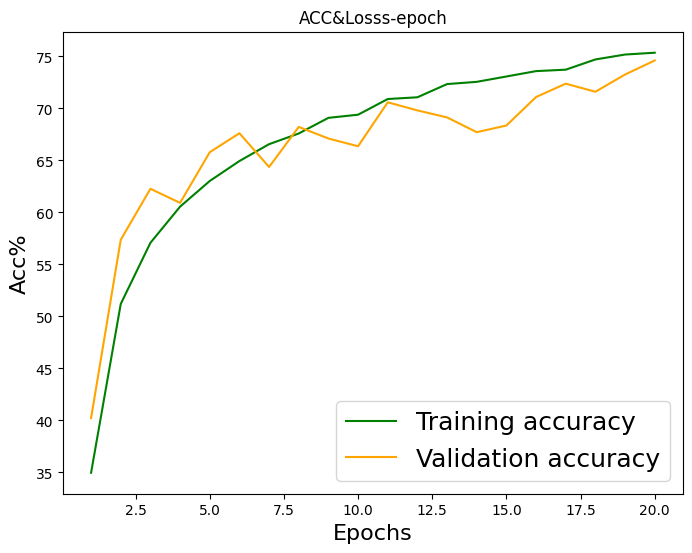

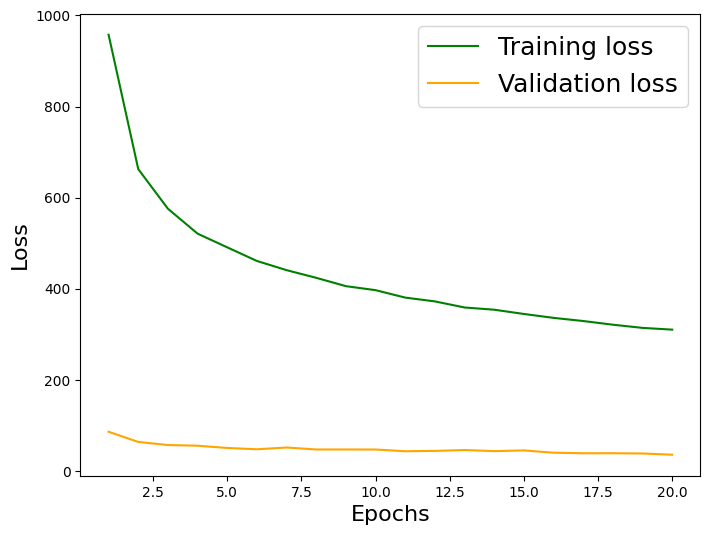

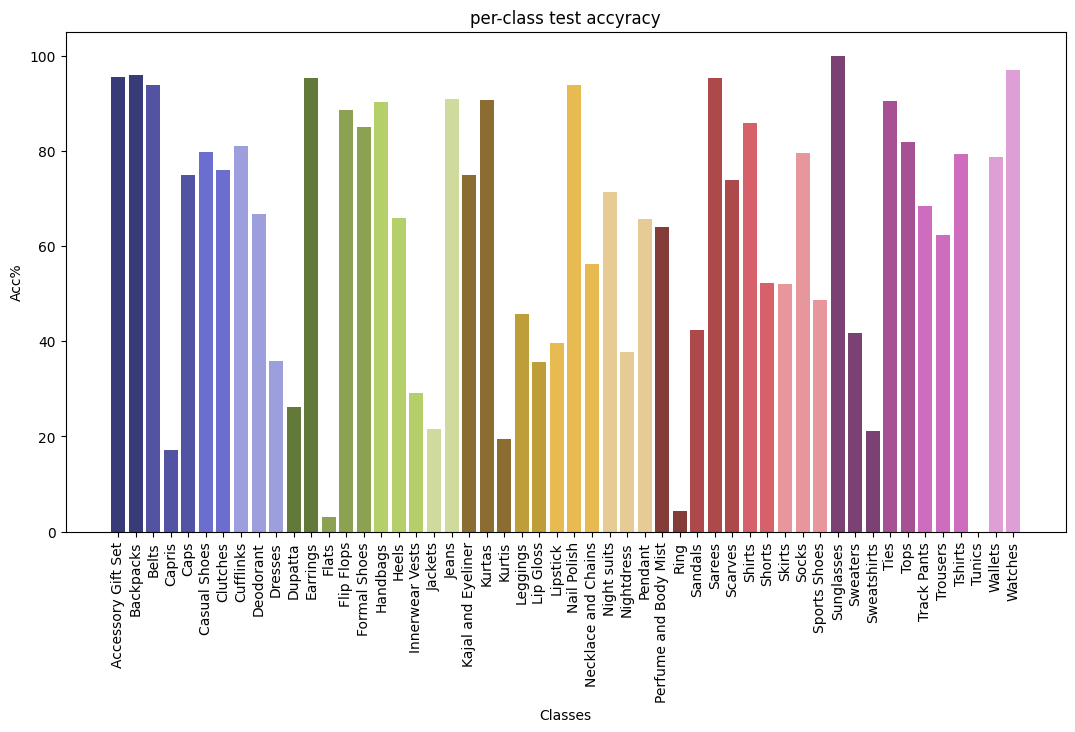

test-acc: 74.74761071476645


In [ ]:
# Example usage
num_features = 3*80*60  # Example input size for dataset
# layers_specification = [(7200, nn.ReLU()), (3600, nn.ReLU())]  # Example hidden layer sizes
# num_classes = 10  # Example number of output classes for classification

model = MLP(input_size=num_features, layers_specification=[(11500, nn.ReLU()), (6500, nn.ReLU())],
            output_size=num_classes, classes_list=classes_list, lr_rate=0.01, momentum=0.5, device='cuda')

# Assuming train_dataloader and valid_dataloader are already defined
model.train(num_epochs=20, train_batch_data=train_dataloader, val_batch_data=valid_dataloader)

acc, tot_test_loss, each_class_acc_list = model.evaluation(test_batch_data=test_dataloader)
model.bar_plot(each_class_acc_list, "test")
print(f"test-acc: {acc*100}")